# Reverse engineering ngmix' gaussian moments

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal

Get a galaxy:

In [3]:
gal, psf = autometacal.data.galaxies.make_data(img_noise=0.001,gal_g1=[0.2],gal_g2=[0.])

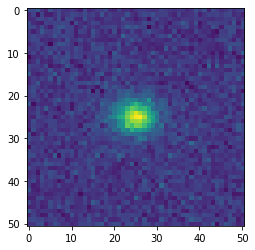

In [4]:
imshow(gal.numpy()[0])
obs=ngmix.Observation(gal.numpy()[0])

Set a fitter with Gaussian moments:

In [5]:
weight_fwhm = 1.2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

calculate moments:

In [6]:
fitter._measure_moments(obs)

{'flags': 0,
 'npix': 2601,
 'wsum': 1.6706505883799125,
 'sums': array([-2.54577813e-04,  2.50707747e-04,  3.82815390e-04,  1.69230218e-05,
         1.14479158e-02,  2.67032991e-02]),
 'sums_cov': array([[ 4.43347585e-02,  6.78187692e-21, -1.35702190e-19,
          1.35617456e-20, -1.55991824e-19, -1.68057271e-18],
        [ 6.78187692e-21,  4.43347585e-02, -6.43763098e-20,
          3.33780411e-20, -5.10081244e-20,  1.74150585e-18],
        [-1.35702190e-19, -6.43763098e-20,  8.50627684e-02,
          6.01159860e-24,  1.14187922e-19,  1.22729489e-18],
        [ 1.35617456e-20,  3.33780411e-20,  6.01159860e-24,
          7.23395244e-03,  1.14822467e-19,  1.35637538e-20],
        [-1.55991824e-19, -5.10081244e-20,  1.14187922e-19,
          1.14822467e-19,  9.22967208e-02,  8.86695171e-02],
        [-1.68057271e-18,  1.74150585e-18,  1.22729489e-18,
          1.35637538e-20,  8.86695171e-02,  1.08685858e+00]]),
 'pars': array([-0.00953357,  0.00938864,  0.01433588,  0.00063374,  0.4287

## How it works?

Let's build the weight map that is also a gaussian mixture (of 1 gaussian...)

In [7]:
wt_gm = fitter.weight.get_data()
dict(zip(wt_gm.dtype.names,[i for i in wt_gm[0]]))

{'p': 1.6316496510577898,
 'row': 0.0,
 'col': 0.0,
 'irr': 0.25968510736001343,
 'irc': 0.0,
 'icc': 0.25968510736001343,
 'det': 0.0674363549845817,
 'norm_set': 1,
 'drr': 3.850817669777474,
 'drc': 0.0,
 'dcc': 3.850817669777474,
 'norm': 0.6128766670906989,
 'pnorm': 1.0}

How it gets build?

In [8]:
T = ngmix.moments.fwhm_to_T(weight_fwhm)

teste=ngmix.GMixModel(
            [0.0, 0.0, 0.0, 0.0, T, 1.0],
            'gauss',
        )
teste.set_norms()
norm = teste.get_data()['norm'][0]
teste.set_flux(1.0/norm)

GMixModel constructor calls the fill functions...

In [ ]:
def gmix_fill_simple(gmix, pars, fvals, pvals):
    """
    fill a simple (6 parameter) gaussian mixture model
    no error checking done here
    """

    row = pars[0]
    col = pars[1]
    g1 = pars[2]
    g2 = pars[3]
    T = pars[4]
    flux = pars[5]

    e1, e2 = g1g2_to_e1e2(g1, g2)

    n_gauss = gmix.size
    for i in range(n_gauss):

        gauss = gmix[i]

        T_i_2 = 0.5 * T * fvals[i]
        flux_i = flux * pvals[i]

        gauss2d_set(
            gauss,
            flux_i,
            row,
            col,
            T_i_2 * (1 - e1),
            T_i_2 * e2,
            T_i_2 * (1 + e1),
        )


In [22]:
wt_gm2=teste._data
wt_gm2['norm_set']=1
wt_gm2['pnorm']=1
dict(zip(wt_gm2.dtype.names,[i for i in wt_gm2[0]]))


{'p': 1.6316496510577898,
 'row': 0.0,
 'col': 0.0,
 'irr': 0.25968510736001343,
 'irc': 0.0,
 'icc': 0.25968510736001343,
 'det': 0.0674363549845817,
 'norm_set': 1,
 'drr': 3.850817669777474,
 'drc': 0.0,
 'dcc': 3.850817669777474,
 'norm': 0.6128766670906989,
 'pnorm': 1.0}

In [23]:
_moments_result_dtype = [
    ('flags', 'i4'),
    ('npix', 'i4'),
    ('wsum', 'f8'),

    ('sums', 'f8', 6),
    ('sums_cov', 'f8', (6, 6)),
    ('pars', 'f8', 6),
    ('F', 'f8', 6),
]

dt = np.dtype(_moments_result_dtype, align=True)
resarray = np.zeros(1, dtype=dt)
res = resarray[0]

def gauss2d_eval_pixel(gauss, pixel):
    """
    evaluate a 2-d gaussian at the specified location
    parameters
    ----------
    gauss2d: gauss2d structure
        row,col,dcc,drr,drc,pnorm... See gmix.py
    pixel: struct with coods
        should have fields v,u
    """
    model_val = 0.0


    # v->row, u->col in gauss
    vdiff = pixel["v"] - gauss["row"]
    udiff = pixel["u"] - gauss["col"]

    chi2 = (
        gauss["dcc"] * vdiff * vdiff
        + gauss["drr"] * udiff * udiff
        - 2.0 * gauss["drc"] * vdiff * udiff
    )

    model_val = gauss["pnorm"] * numpy.exp(-0.5 * chi2) * pixel["area"]

    return model_val
  
def gmix_eval_pixel(gmix, pixel):
    """
    evaluate a single gaussian mixture
    """
    model_val = 0.0
    for igauss in range(gmix.size):

        model_val += gauss2d_eval_pixel(gmix[igauss], pixel,)

    return model_val

def get_weighted_sums(wt, pixels, res, maxrad):
    """
    do sums for calculating the weighted moments
    """

    maxrad2 = maxrad ** 2

    vcen = wt["row"][0]
    ucen = wt["col"][0]
    F = res["F"]

    n_pixels = pixels.size
    for i_pixel in range(n_pixels):

        pixel = pixels[i_pixel]

        vmod = pixel["v"] - vcen
        umod = pixel["u"] - ucen

        rad2 = umod * umod + vmod * vmod
        if rad2 < maxrad2:

            weight = gmix_eval_pixel(wt, pixel)
            var = 1.0 / (pixel["ierr"] * pixel["ierr"])
            
            wdata = weight * pixel["val"]
            
            w2 = weight * weight


            F[0] = pixel["v"]
            F[1] = pixel["u"]
            F[2] = umod * umod - vmod * vmod
            F[3] = 2 * vmod * umod
            F[4] = rad2
            F[5] = 1.0

            res["wsum"] += weight
            res["npix"] += 1

            for i in range(6):

                res["sums"][i] += wdata * F[i]
                for j in range(6):
                    res["sums_cov"][i, j] += w2 * var * F[i] * F[j]

get_weighted_sums(wt_gm2,obs.pixels,res,400)
res=dict(zip(res.dtype.names,res))
res

{'flags': 0,
 'npix': 2601,
 'wsum': 1.6706505883799125,
 'sums': array([-2.54577813e-04,  2.50707747e-04,  3.82815390e-04,  1.69230218e-05,
         1.14479158e-02,  2.67032991e-02]),
 'sums_cov': array([[ 4.43347585e-02,  6.78187692e-21, -1.35702190e-19,
          1.35617456e-20, -1.55991824e-19, -1.68057271e-18],
        [ 6.78187692e-21,  4.43347585e-02, -6.43763098e-20,
          3.33780411e-20, -5.10081244e-20,  1.74150585e-18],
        [-1.35702190e-19, -6.43763098e-20,  8.50627684e-02,
          6.01159860e-24,  1.14187922e-19,  1.22729489e-18],
        [ 1.35617456e-20,  3.33780411e-20,  6.01159860e-24,
          7.23395244e-03,  1.14822467e-19,  1.35637538e-20],
        [-1.55991824e-19, -5.10081244e-20,  1.14187922e-19,
          1.14822467e-19,  9.22967208e-02,  8.86695171e-02],
        [-1.68057271e-18,  1.74150585e-18,  1.22729489e-18,
          1.35637538e-20,  8.86695171e-02,  1.08685858e+00]]),
 'pars': array([0., 0., 0., 0., 0., 0.]),
 'F': array([2.50e+01, 2.50e+01, 

In [12]:
res=fitter.weight.get_weighted_moments(obs=obs, maxrad=40)
res

{'flags': 0,
 'npix': 2601,
 'wsum': 1.6706505883799125,
 'sums': array([-2.54577813e-04,  2.50707747e-04,  3.82815390e-04,  1.69230218e-05,
         1.14479158e-02,  2.67032991e-02]),
 'sums_cov': array([[ 4.43347585e-02,  6.78187692e-21, -1.35702190e-19,
          1.35617456e-20, -1.55991824e-19, -1.68057271e-18],
        [ 6.78187692e-21,  4.43347585e-02, -6.43763098e-20,
          3.33780411e-20, -5.10081244e-20,  1.74150585e-18],
        [-1.35702190e-19, -6.43763098e-20,  8.50627684e-02,
          6.01159860e-24,  1.14187922e-19,  1.22729489e-18],
        [ 1.35617456e-20,  3.33780411e-20,  6.01159860e-24,
          7.23395244e-03,  1.14822467e-19,  1.35637538e-20],
        [-1.55991824e-19, -5.10081244e-20,  1.14187922e-19,
          1.14822467e-19,  9.22967208e-02,  8.86695171e-02],
        [-1.68057271e-18,  1.74150585e-18,  1.22729489e-18,
          1.35637538e-20,  8.86695171e-02,  1.08685858e+00]]),
 'pars': array([-0.00953357,  0.00938864,  0.01433588,  0.00063374,  0.4287